In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tenpy.models.lattice import Square
from tenpy.networks.site import SpinHalfFermionSite
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel
from tenpy.models.hubbard import FermiHubbardModel
from tenpy.algorithms import dmrg

In [2]:
class FermiHubbardSquare(CouplingMPOModel):
  
  def init_lattice(self, model_params):
    L = model_params.get('L', 1)
    
    site = SpinHalfFermionSite()
    lattice = Square(L, L, site, bc = "open")
    
    return lattice

  def init_terms(self, model_params):
    L = model_params.get('L', 1)
    t = model_params.get('t', 1.0)
    
    U = model_params.get('U', 0.0)
    mu = model_params.get('mu', 0.0)

    for u in range(len(self.lat.unit_cell)):
      print("Adding onsite term:", u)
      self.add_onsite(-mu, u, 'Ntot')
      self.add_onsite(U, u, 'NuNd')
    
    for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
      print("Adding coupling term:", u1, u2, dx)
      self.add_coupling(-t, u1, 'Cdu', u2, 'Cu', dx, plus_hc = True)
      self.add_coupling(-t, u1, 'Cdd', u2, 'Cd', dx, plus_hc = True)
      
  def show(self):
    print("Boundary:", self.lat.boundary_conditions)
    
    plt.figure(figsize = (6, 6))
    
    ax = plt.gca()
    
    self.lat.plot_coupling(ax)
    self.lat.plot_order(ax, linestyle = ':')
    self.lat.plot_sites(ax)
    
    plt.show()

In [3]:
def make_state(M, pairs):
  N = len(M.lat.mps_sites())
  
  # NOTE: This is not likely a very good initial guess!
  
  state = ['full' for i in range(pairs)] + ['empty' for i in range(N - pairs)]

  psi = MPS.from_product_state(
    M.lat.mps_sites(),
    state,
    bc = M.lat.bc_MPS
  )
  
  return psi

Adding onsite term: 0
Adding coupling term: 0 0 [1 0]
Adding coupling term: 0 0 [0 1]
Boundary: ['open', 'open']


/home/matthew/Documents/research/msu/qiskit-env/lib/python3.10/site-packages/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config FermiHubbardSquare
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


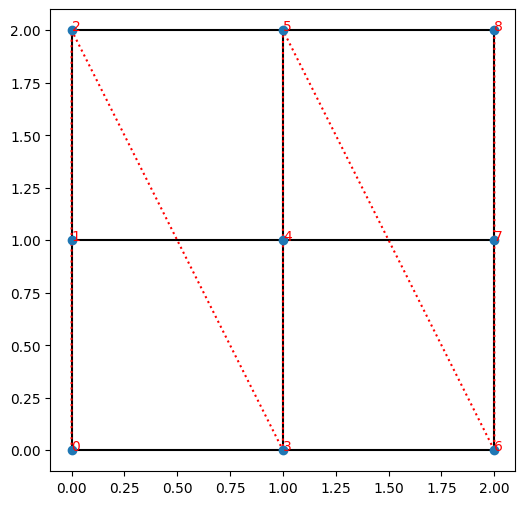

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.85e-05


E = 2.3303668732295


/home/matthew/Documents/research/msu/qiskit-env/lib/python3.10/site-packages/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [4]:
# 3 pairs on a 3x3 lattice

model_params = dict(
  L = 3,
  t = 1,
  mu = -2,
  U = 2,
  verbose = False
)

M = FermiHubbardSquare(model_params)

M.show()

dmrg_params = {
  'mixer': True,
  'trunc_params': {
    'chi_max': 100,
    'svd_min': 1.0e-10,
  },
  'max_E_err': 1.0e-10,
  'verbose': False,
}

psi = make_state(M, 3)

info = dmrg.run(psi, M, dmrg_params)

E = info['E']

print("E = {E:.13f}".format(E = E))